# exploration 16번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [1]:
import os
import datetime as dt
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## 상수선언

In [2]:
BASE_PATH = Path(os.getcwd()+"/data") # 기본 데이터경로
DATA_PATH = BASE_PATH / 'ratings.dat' # 모델경로
COL_NAMES = ['UserId', 'ItemId', 'Rating', 'Time']

## 함수

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(
      data_path
      , sep='::'
      , header=None
      , engine='python'
      , usecols=[0, 1, 2, 3]
      , dtype={0: np.int32, 1: np.int32, 2: np.int32}
      , nrows=nrows
    )
    data.columns = COL_NAMES
    return data

## 메인

### 전처리

In [4]:
data = load_data(DATA_PATH, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data['Time'] = pd.to_datetime(data['Time'], unit='s') #시간 형식 변경
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


`SessionID`데이터가 없어 대신 `UserID` 항목을 유저를 구분하는 키로 사용하였다.<br>
`Rating` 정보가 추가되었으며 `Rating`이 낮은 데이터는 유저가 선호하지 않는 영화로 판단<br>
그 기준을 3미만으로 보았다.<br>
`Time` 항목에는 `UTC time`기준으로 데이터가 들어가있으므로 이에 맞게 시간을 변경하였다.

In [5]:
session_length = data.groupby('UserId').size()
print("session_length")
print(session_length)
print(f"median={session_length.median()}, mean={session_length.mean()}")
print(f"min={session_length.min()}, max={session_length.max()}")
print(f"quantile(99%)={session_length.quantile(0.99)}")

session_length
UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64
median=96.0, mean=165.5975165562914
min=20, max=2314
quantile(99%)=906.659999999998


유저에 대해 영화의 평가에 대한 각 데이터의 통계값을 산출하였다.<br>
상위 99%일 경우 평균에 비해 평가한 횟수가 비정상적으로 높은 것을 확인할 수 있다.

In [6]:
long_session = session_length[session_length>session_length.quantile(0.99)].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
62523,424,3048,2,2000-12-08 13:14:03
62998,424,3101,3,2000-12-08 13:14:03
63189,424,2565,3,2000-12-08 13:14:03
63582,424,2042,2,2000-12-08 13:14:48
62475,424,750,4,2000-12-08 13:16:58
62542,424,924,5,2000-12-08 13:16:58
62779,424,260,5,2000-12-08 13:16:58
62962,424,1196,5,2000-12-08 13:16:58
63165,424,2554,3,2000-12-08 13:16:58
63515,424,541,5,2000-12-08 13:16:58


상위 99%의 데이터 중 하나를 뽑아서 데이터를 확인해본 결과<br>
1초당 많게는 6번정도 평가한 기록이보인다.<br>
이는 메크로를 통해 랜덤으로 평가를 주는것 같이 보인다.

Text(0.5, 1.0, 'Cumsum Percentage Until 0.99')

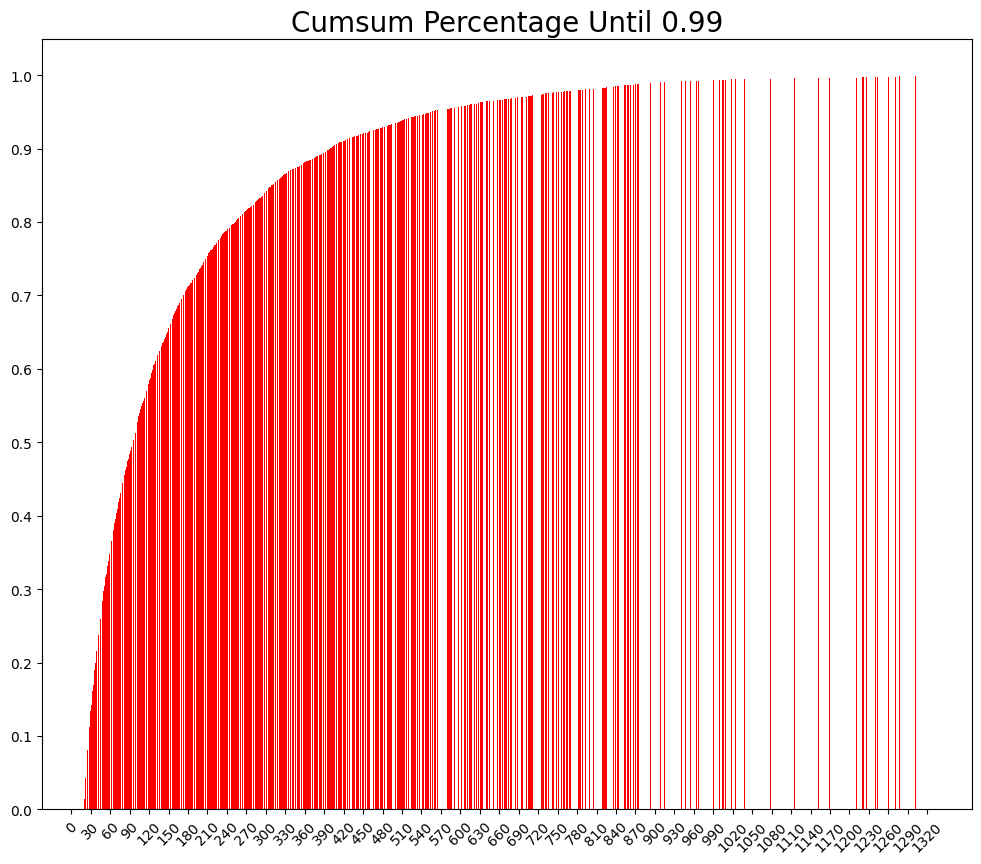

In [7]:
#하위 99% 세션 길이 분포 누적합 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_99.index,
        height = length_percent_cumsum_99, color = 'red')
plt.xticks(np.arange(0, 1350, 30), rotation=45)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Cumsum Percentage Until 0.99', size=20)

990 ~ 1020 구간부터 급속도로 데이터가 줄어드는 경향이 보인다.

In [8]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(f"oldest time={oldest}, latest time={latest}, delta={latest - oldest}")

oldest time=2000-04-25 23:05:32, latest time=2003-02-28 17:49:50, delta=1038 days 18:44:18


가장 오래된 데이터와 최신데이터를 약 3년치의 데이터가 있다는 사실을 알 수 있다.

In [10]:
# Data Cleansing

def cleanse_recursive(data: pd.DataFrame, shortest, least_watch) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_watch)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

def split_by_date(data: pd.DataFrame, rating_tol:int, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]

    before_date = before_date[before_date["Rating"] > rating_tol]
    after_date = after_date[after_date["Rating"] > rating_tol]
    return before_date, after_date

유저가 선호하지 않는 영화의 기준이 3점 미만이라 가정하고<br>
3점 미만의 데이터는 추천에서 제외하기위해 제거하였다.

In [11]:
#test,val을 3달 기준 데이터로 나눔
tr, test = split_by_date(data, 180)
tr, val = split_by_date(tr, 180)

In [12]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [13]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 681084
	 Users: 5554
	 Items: 3579
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 22:46:11

* valid Set Stats Info
	 Events: 41184
	 Users: 152
	 Items: 3037
	 First Time : 2000-05-01 20:45:43
	 Last Time : 2002-09-01 00:14:13

* test Set Stats Info
	 Events: 114151
	 Users: 333
	 Items: 3289
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [14]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df
    
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [15]:
# 저장

save_path = BASE_PATH / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [16]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [17]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [18]:
# session data loader

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=64):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1   # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [19]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=64)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [20]:
iter_ex = iter(tr_data_loader)
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0   53   64   54  201  325    1   54  458  370   53  753   37  782
  789  845  855  672  897   16  948   76  201   87 1160   64  493    9
 1302  325 1324   87 1225 1418  111  970  536 1484   79   32    9  118
 1488 1264 1563    9   37  152 1584  234   64  672    9  399  672 1791
  371 1497 1614  234  287   53   16 1095]
Label Item Idx are :       [   1   54   62   24   12  135  127  381   15  492  536  754  171  783
   53  528    9  642   64  234 1035 1039 1090  163   53 1146  483 1293
 1080   24 1325  325   41 1419 1426   35  325  234  414  958  125   15
  352   79  728  337    9 1630 1636   48  396 1221   11   64 1406  371
  581  146  837  977 1898  419  118 1146]
Previous Masked Input Idx are []


In [21]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [22]:
# tensorflow import

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [23]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy
                  , optimizer=Adam(args.lr)
                  , metrics=['accuracy'])
    model.summary()
    
    return model

In [24]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50
            , drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [25]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 1, 3579)]           0         
                                                                 
 GRU (GRU)                   [(64, 50),                544650    
                              (64, 50)]                          
                                                                 
 dropout (Dropout)           (64, 50)                  0         
                                                                 
 dense (Dense)               (64, 3579)                182529    
                                                                 
Total params: 727,179
Trainable params: 727,179
Non-trainable params: 0
_________________________________________________________________


In [26]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size
                         , desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### 검증


In [27]:
train_model(model, args)

Evaluation:   0%|          | 0/641 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   0%|          | 2/641 [00:01<07:04,  1.51it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   1%|          | 5/641 [00:02<05:22,  1.97it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   1%|          | 8/641 [00:03<05:02,  2.09it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   2%|▏         | 11/641 [00:05<04:54,  2.14it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 14/641 [00:06<04:47,  2.18it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   3%|▎         | 17/641 [00:08<04:47,  2.17it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   3%|▎         | 20/641 [00:09<04:32,  2.28it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   4%|▎         | 23/641 [00:10<04:26,  2.32it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▍         | 26/641 [00:11<04:24,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   5%|▍         | 29/641 [00:12<04:18,  2.37it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   5%|▍         | 32/641 [00:14<04:16,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   5%|▌         | 35/641 [00:15<04:23,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   6%|▌         | 38/641 [00:16<04:22,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   6%|▋         | 41/641 [00:18<04:25,  2.26it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   7%|▋         | 44/641 [00:19<04:18,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   7%|▋         | 47/641 [00:20<04:14,  2.33it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   8%|▊         | 50/641 [00:22<04:10,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   8%|▊         | 53/641 [00:23<04:08,  2.37it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   9%|▊         | 56/641 [00:24<04:07,  2.36it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:   9%|▉         | 59/641 [00:25<04:07,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  10%|▉         | 62/641 [00:27<04:09,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  10%|█         | 65/641 [00:28<04:05,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  11%|█         | 68/641 [00:29<04:03,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


Evaluation:  11%|█         | 71/641 [00:30<04:00,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  12%|█▏        | 74/641 [00:32<03:59,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  12%|█▏        | 77/641 [00:33<04:05,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  12%|█▏        | 80/641 [00:34<04:03,  2.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  13%|█▎        | 83/641 [00:36<04:04,  2.29it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  13%|█▎        | 86/641 [00:37<04:02,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  14%|█▍        | 89/641 [00:38<04:04,  2.26it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  14%|█▍        | 92/641 [00:40<04:03,  2.25it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  15%|█▍        | 95/641 [00:41<04:00,  2.27it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  15%|█▌        | 98/641 [00:42<03:54,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  16%|█▌        | 101/641 [00:44<03:49,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  16%|█▌        | 104/641 [00:45<03:51,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  17%|█▋        | 107/641 [00:46<03:49,  2.33it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 110/641 [00:47<03:45,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  18%|█▊        | 113/641 [00:49<03:46,  2.33it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  18%|█▊        | 116/641 [00:50<03:47,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  19%|█▊        | 119/641 [00:51<03:47,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  19%|█▉        | 122/641 [00:53<03:46,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  20%|█▉        | 125/641 [00:54<03:47,  2.27it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  20%|█▉        | 128/641 [00:55<03:46,  2.26it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  20%|██        | 131/641 [00:57<03:44,  2.28it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  21%|██        | 134/641 [00:58<03:46,  2.24it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  21%|██▏       | 137/641 [00:59<03:43,  2.26it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  22%|██▏       | 140/641 [01:01<03:41,  2.27it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  22%|██▏       | 143/641 [01:02<03:39,  2.27it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  23%|██▎       | 146/641 [01:03<03:37,  2.27it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  23%|██▎       | 149/641 [01:05<03:36,  2.27it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  24%|██▎       | 152/641 [01:06<03:37,  2.25it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  24%|██▍       | 155/641 [01:07<03:43,  2.18it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  25%|██▍       | 158/641 [01:09<03:34,  2.26it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  25%|██▌       | 161/641 [01:10<03:29,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  26%|██▌       | 164/641 [01:11<03:27,  2.30it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  26%|██▌       | 167/641 [01:13<03:25,  2.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  27%|██▋       | 170/641 [01:14<03:22,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  27%|██▋       | 173/641 [01:15<03:20,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  27%|██▋       | 176/641 [01:16<03:18,  2.34it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  28%|██▊       | 179/641 [01:18<03:18,  2.32it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  28%|██▊       | 182/641 [01:19<03:19,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  29%|██▉       | 185/641 [01:20<03:19,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▉       | 188/641 [01:22<03:24,  2.22it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  30%|██▉       | 191/641 [01:23<03:22,  2.23it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  30%|███       | 194/641 [01:24<03:15,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  31%|███       | 197/641 [01:26<03:10,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


Evaluation:  31%|███       | 200/641 [01:27<03:09,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  32%|███▏      | 203/641 [01:28<03:09,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  32%|███▏      | 206/641 [01:30<03:10,  2.28it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  33%|███▎      | 209/641 [01:31<03:08,  2.29it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  33%|███▎      | 212/641 [01:32<03:09,  2.26it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  34%|███▎      | 215/641 [01:34<03:10,  2.24it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  34%|███▍      | 218/641 [01:35<03:06,  2.27it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  34%|███▍      | 221/641 [01:36<03:02,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  35%|███▍      | 224/641 [01:37<03:01,  2.29it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  35%|███▌      | 227/641 [01:39<03:01,  2.28it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  36%|███▌      | 230/641 [01:40<03:01,  2.26it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  36%|███▋      | 233/641 [01:41<03:01,  2.25it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 236/641 [01:43<02:58,  2.27it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  37%|███▋      | 239/641 [01:44<02:55,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  38%|███▊      | 242/641 [01:45<02:52,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  38%|███▊      | 245/641 [01:47<02:51,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  39%|███▊      | 248/641 [01:48<02:50,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  39%|███▉      | 251/641 [01:49<02:49,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  40%|███▉      | 254/641 [01:51<02:47,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  40%|████      | 257/641 [01:52<02:43,  2.35it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  41%|████      | 260/641 [01:53<02:42,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  41%|████      | 263/641 [01:54<02:40,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  41%|████▏     | 266/641 [01:56<02:39,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  42%|████▏     | 269/641 [01:57<02:38,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  42%|████▏     | 272/641 [01:58<02:36,  2.35it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  43%|████▎     | 275/641 [01:59<02:34,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  43%|████▎     | 278/641 [02:01<02:33,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▍     | 281/641 [02:02<02:31,  2.37it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  44%|████▍     | 284/641 [02:03<02:30,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  45%|████▍     | 287/641 [02:04<02:29,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  45%|████▌     | 290/641 [02:06<02:28,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  46%|████▌     | 293/641 [02:07<02:26,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  46%|████▌     | 296/641 [02:08<02:26,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  47%|████▋     | 299/641 [02:10<02:25,  2.35it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  47%|████▋     | 302/641 [02:11<02:24,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  48%|████▊     | 305/641 [02:12<02:21,  2.37it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  48%|████▊     | 308/641 [02:13<02:22,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  49%|████▊     | 311/641 [02:15<02:22,  2.32it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  49%|████▉     | 314/641 [02:16<02:20,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  49%|████▉     | 317/641 [02:17<02:19,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  50%|████▉     | 320/641 [02:19<02:17,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  50%|█████     | 323/641 [02:20<02:16,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  51%|█████     | 326/641 [02:21<02:14,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  51%|█████▏    | 329/641 [02:22<02:13,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  52%|█████▏    | 332/641 [02:24<02:12,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  52%|█████▏    | 335/641 [02:25<02:11,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  53%|█████▎    | 338/641 [02:26<02:09,  2.34it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  53%|█████▎    | 341/641 [02:28<02:09,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  54%|█████▎    | 344/641 [02:29<02:12,  2.24it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  54%|█████▍    | 347/641 [02:30<02:11,  2.23it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  55%|█████▍    | 350/641 [02:32<02:09,  2.25it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  55%|█████▌    | 353/641 [02:33<02:07,  2.26it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  56%|█████▌    | 356/641 [02:34<02:04,  2.28it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  56%|█████▌    | 359/641 [02:36<02:01,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  56%|█████▋    | 362/641 [02:37<01:59,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  57%|█████▋    | 365/641 [02:38<01:57,  2.35it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  57%|█████▋    | 368/641 [02:39<01:56,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  58%|█████▊    | 371/641 [02:41<01:55,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  58%|█████▊    | 374/641 [02:42<01:54,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  59%|█████▉    | 377/641 [02:43<01:52,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  59%|█████▉    | 380/641 [02:44<01:50,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  60%|█████▉    | 383/641 [02:46<01:49,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  60%|██████    | 386/641 [02:47<01:47,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  61%|██████    | 389/641 [02:48<01:46,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  61%|██████    | 392/641 [02:49<01:45,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  62%|██████▏   | 395/641 [02:51<01:44,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  62%|██████▏   | 398/641 [02:52<01:43,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  63%|██████▎   | 401/641 [02:53<01:44,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  63%|██████▎   | 404/641 [02:55<01:42,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  63%|██████▎   | 407/641 [02:56<01:40,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  64%|██████▍   | 410/641 [02:57<01:40,  2.29it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  64%|██████▍   | 413/641 [02:59<01:38,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  65%|██████▍   | 416/641 [03:00<01:36,  2.34it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  65%|██████▌   | 419/641 [03:01<01:34,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  66%|██████▌   | 422/641 [03:02<01:33,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  66%|██████▋   | 425/641 [03:04<01:32,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  67%|██████▋   | 428/641 [03:05<01:31,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  67%|██████▋   | 431/641 [03:06<01:30,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  68%|██████▊   | 434/641 [03:08<01:28,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  68%|██████▊   | 437/641 [03:09<01:27,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  69%|██████▊   | 440/641 [03:10<01:26,  2.31it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  69%|██████▉   | 443/641 [03:11<01:25,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  70%|██████▉   | 446/641 [03:13<01:24,  2.30it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  70%|███████   | 449/641 [03:14<01:24,  2.27it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  70%|███████   | 451/641 [03:15<01:22,  2.31it/s]


	 - Recall@20 epoch 1: 0.201150
	 - MRR@20    epoch 1: 0.050676



Evaluation:   0%|          | 0/641 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   0%|          | 3/641 [00:01<04:45,  2.24it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   1%|          | 6/641 [00:02<04:29,  2.36it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:   1%|▏         | 9/641 [00:03<04:16,  2.47it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   2%|▏         | 12/641 [00:04<04:08,  2.53it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:   2%|▏         | 15/641 [00:06<04:14,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   3%|▎         | 18/641 [00:07<04:10,  2.49it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   3%|▎         | 21/641 [00:08<04:03,  2.54it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   4%|▎         | 24/641 [00:09<04:04,  2.52it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   4%|▍         | 27/641 [00:10<04:03,  2.52it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   5%|▍         | 30/641 [00:11<03:59,  2.55it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   5%|▌         | 33/641 [00:13<04:01,  2.52it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   6%|▌         | 36/641 [00:14<03:59,  2.52it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   6%|▌         | 39/641 [00:15<03:58,  2.52it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   7%|▋         | 42/641 [00:16<04:00,  2.49it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 45/641 [00:18<03:59,  2.49it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   7%|▋         | 48/641 [00:19<03:59,  2.47it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:   8%|▊         | 51/641 [00:20<03:59,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   8%|▊         | 54/641 [00:21<03:59,  2.45it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:   9%|▉         | 57/641 [00:22<03:58,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   9%|▉         | 60/641 [00:24<03:56,  2.46it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  10%|▉         | 63/641 [00:25<03:54,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  10%|█         | 66/641 [00:26<03:52,  2.48it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  11%|█         | 69/641 [00:27<03:51,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  11%|█         | 72/641 [00:28<03:49,  2.48it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  12%|█▏        | 75/641 [00:30<03:47,  2.48it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  12%|█▏        | 78/641 [00:31<03:48,  2.47it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  13%|█▎        | 81/641 [00:32<03:47,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  13%|█▎        | 84/641 [00:33<03:46,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  14%|█▎        | 87/641 [00:35<03:48,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  14%|█▍        | 90/641 [00:36<03:45,  2.44it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  15%|█▍        | 93/641 [00:37<03:47,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  15%|█▍        | 96/641 [00:38<03:45,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  15%|█▌        | 99/641 [00:40<03:43,  2.42it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  16%|█▌        | 102/641 [00:41<03:39,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  16%|█▋        | 105/641 [00:42<03:39,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  17%|█▋        | 108/641 [00:43<03:39,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  17%|█▋        | 111/641 [00:45<03:38,  2.42it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  18%|█▊        | 114/641 [00:46<03:38,  2.42it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  18%|█▊        | 117/641 [00:47<03:39,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


Evaluation:  19%|█▊        | 120/641 [00:48<03:41,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  19%|█▉        | 123/641 [00:50<03:39,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  20%|█▉        | 126/641 [00:51<03:39,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  20%|██        | 129/641 [00:52<03:37,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  21%|██        | 132/641 [00:53<03:34,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  21%|██        | 135/641 [00:55<03:33,  2.37it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  22%|██▏       | 138/641 [00:56<03:30,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  22%|██▏       | 141/641 [00:57<03:27,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  22%|██▏       | 144/641 [00:58<03:25,  2.42it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  23%|██▎       | 147/641 [01:00<03:24,  2.42it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  23%|██▎       | 150/641 [01:01<03:24,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  24%|██▍       | 153/641 [01:02<03:22,  2.41it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  24%|██▍       | 156/641 [01:03<03:19,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  25%|██▍       | 159/641 [01:05<03:16,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  25%|██▌       | 162/641 [01:06<03:13,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  26%|██▌       | 165/641 [01:07<03:13,  2.46it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  26%|██▌       | 168/641 [01:08<03:14,  2.43it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  27%|██▋       | 171/641 [01:09<03:13,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  27%|██▋       | 174/641 [01:11<03:13,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  28%|██▊       | 177/641 [01:12<03:12,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  28%|██▊       | 180/641 [01:13<03:12,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▊       | 183/641 [01:15<03:11,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▉       | 186/641 [01:16<03:11,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▉       | 189/641 [01:17<03:12,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  30%|██▉       | 192/641 [01:18<03:10,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  30%|███       | 195/641 [01:20<03:06,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  31%|███       | 198/641 [01:21<03:04,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  31%|███▏      | 201/641 [01:22<03:03,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  32%|███▏      | 204/641 [01:23<03:02,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  32%|███▏      | 207/641 [01:25<03:03,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  33%|███▎      | 210/641 [01:26<03:01,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  33%|███▎      | 213/641 [01:27<03:00,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  34%|███▎      | 216/641 [01:28<02:58,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  34%|███▍      | 219/641 [01:30<02:57,  2.38it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  35%|███▍      | 222/641 [01:31<02:54,  2.41it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  35%|███▌      | 225/641 [01:32<02:53,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  36%|███▌      | 228/641 [01:33<02:52,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  36%|███▌      | 231/641 [01:35<02:50,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 234/641 [01:36<02:48,  2.42it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 237/641 [01:37<02:46,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  37%|███▋      | 240/641 [01:38<02:45,  2.43it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  38%|███▊      | 243/641 [01:40<02:45,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  38%|███▊      | 246/641 [01:41<02:44,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  39%|███▉      | 249/641 [01:42<02:44,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  39%|███▉      | 252/641 [01:43<02:43,  2.38it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  40%|███▉      | 255/641 [01:45<02:41,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  40%|████      | 258/641 [01:46<02:39,  2.41it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  41%|████      | 261/641 [01:47<02:39,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  41%|████      | 264/641 [01:48<02:36,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  42%|████▏     | 267/641 [01:50<02:36,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  42%|████▏     | 270/641 [01:51<02:33,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  43%|████▎     | 273/641 [01:52<02:32,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  43%|████▎     | 276/641 [01:53<02:30,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  44%|████▎     | 279/641 [01:55<02:30,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▍     | 282/641 [01:56<02:30,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▍     | 285/641 [01:57<02:28,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  45%|████▍     | 288/641 [01:58<02:26,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  45%|████▌     | 291/641 [02:00<02:26,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  46%|████▌     | 294/641 [02:01<02:24,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  46%|████▋     | 297/641 [02:02<02:23,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  47%|████▋     | 300/641 [02:03<02:23,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  47%|████▋     | 303/641 [02:05<02:21,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  48%|████▊     | 306/641 [02:06<02:18,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  48%|████▊     | 309/641 [02:07<02:19,  2.39it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▊     | 312/641 [02:08<02:18,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  49%|████▉     | 315/641 [02:10<02:16,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  50%|████▉     | 318/641 [02:11<02:20,  2.29it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  50%|█████     | 321/641 [02:12<02:17,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  51%|█████     | 324/641 [02:14<02:14,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  51%|█████     | 327/641 [02:15<02:12,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  51%|█████▏    | 330/641 [02:16<02:10,  2.39it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  52%|█████▏    | 333/641 [02:17<02:10,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  52%|█████▏    | 336/641 [02:19<02:08,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  53%|█████▎    | 339/641 [02:20<02:07,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  53%|█████▎    | 342/641 [02:21<02:05,  2.39it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  54%|█████▍    | 345/641 [02:22<02:04,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  54%|█████▍    | 348/641 [02:24<02:03,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  55%|█████▍    | 351/641 [02:25<02:02,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  55%|█████▌    | 354/641 [02:26<02:01,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  56%|█████▌    | 357/641 [02:27<01:59,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  56%|█████▌    | 360/641 [02:29<01:57,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  57%|█████▋    | 363/641 [02:30<01:55,  2.41it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  57%|█████▋    | 366/641 [02:31<01:54,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  58%|█████▊    | 369/641 [02:32<01:53,  2.40it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 372/641 [02:34<01:52,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  59%|█████▊    | 375/641 [02:35<01:51,  2.38it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  59%|█████▉    | 378/641 [02:36<01:50,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  59%|█████▉    | 381/641 [02:37<01:48,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  60%|█████▉    | 384/641 [02:39<01:47,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  60%|██████    | 387/641 [02:40<01:46,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  61%|██████    | 390/641 [02:41<01:44,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  61%|██████▏   | 393/641 [02:42<01:43,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  62%|██████▏   | 396/641 [02:44<01:41,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  62%|██████▏   | 399/641 [02:45<01:41,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  63%|██████▎   | 402/641 [02:46<01:40,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  63%|██████▎   | 405/641 [02:48<01:39,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  64%|██████▎   | 408/641 [02:49<01:38,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


Evaluation:  64%|██████▍   | 411/641 [02:50<01:37,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  65%|██████▍   | 414/641 [02:51<01:35,  2.38it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  65%|██████▌   | 417/641 [02:53<01:34,  2.38it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  66%|██████▌   | 420/641 [02:54<01:32,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  66%|██████▌   | 423/641 [02:55<01:31,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  66%|██████▋   | 426/641 [02:56<01:30,  2.37it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  67%|██████▋   | 429/641 [02:58<01:29,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  67%|██████▋   | 432/641 [02:59<01:28,  2.36it/s]

1/1 [==============================] - 0s 72ms/step


Evaluation:  68%|██████▊   | 435/641 [03:00<01:28,  2.32it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  68%|██████▊   | 438/641 [03:02<01:28,  2.29it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  69%|██████▉   | 441/641 [03:03<01:26,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  69%|██████▉   | 444/641 [03:04<01:25,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  70%|██████▉   | 447/641 [03:05<01:23,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  70%|███████   | 450/641 [03:07<01:22,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  70%|███████   | 451/641 [03:07<01:19,  2.40it/s]


	 - Recall@20 epoch 2: 0.248129
	 - MRR@20    epoch 2: 0.067864



Evaluation:   0%|          | 0/641 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   0%|          | 3/641 [00:01<05:05,  2.09it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   1%|          | 6/641 [00:02<04:43,  2.24it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   1%|▏         | 9/641 [00:03<04:22,  2.41it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   2%|▏         | 12/641 [00:04<04:13,  2.49it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   2%|▏         | 15/641 [00:06<04:13,  2.47it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   3%|▎         | 18/641 [00:07<04:10,  2.49it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   3%|▎         | 21/641 [00:08<04:05,  2.53it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▎         | 24/641 [00:09<04:01,  2.56it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   4%|▍         | 27/641 [00:10<04:06,  2.49it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   5%|▍         | 30/641 [00:12<04:07,  2.47it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   5%|▌         | 33/641 [00:13<04:03,  2.50it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   6%|▌         | 36/641 [00:14<04:00,  2.52it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   6%|▌         | 39/641 [00:15<03:57,  2.54it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   7%|▋         | 42/641 [00:16<03:59,  2.50it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   7%|▋         | 45/641 [00:18<04:01,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   7%|▋         | 48/641 [00:19<04:02,  2.45it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:   8%|▊         | 51/641 [00:20<04:02,  2.44it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   8%|▊         | 54/641 [00:21<04:04,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   9%|▉         | 57/641 [00:23<04:06,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   9%|▉         | 60/641 [00:24<04:01,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  10%|▉         | 63/641 [00:25<03:58,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  10%|█         | 66/641 [00:26<03:54,  2.45it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  11%|█         | 69/641 [00:28<03:52,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  11%|█         | 72/641 [00:29<03:47,  2.50it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  12%|█▏        | 75/641 [00:30<03:44,  2.52it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  12%|█▏        | 78/641 [00:31<03:44,  2.51it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  13%|█▎        | 81/641 [00:32<03:42,  2.51it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  13%|█▎        | 84/641 [00:34<03:42,  2.50it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  14%|█▎        | 87/641 [00:35<03:44,  2.46it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  14%|█▍        | 90/641 [00:36<03:46,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  15%|█▍        | 93/641 [00:37<03:49,  2.39it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  15%|█▍        | 96/641 [00:39<03:53,  2.33it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  15%|█▌        | 99/641 [00:40<03:53,  2.32it/s]

1/1 [==============================] - 0s 62ms/step


Evaluation:  16%|█▌        | 102/641 [00:41<03:55,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  16%|█▋        | 105/641 [00:43<03:51,  2.31it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  17%|█▋        | 108/641 [00:44<03:51,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  17%|█▋        | 111/641 [00:45<03:58,  2.23it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  18%|█▊        | 114/641 [00:47<03:58,  2.21it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  18%|█▊        | 117/641 [00:48<03:53,  2.25it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  19%|█▊        | 120/641 [00:49<03:46,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  19%|█▉        | 123/641 [00:51<03:40,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  20%|█▉        | 126/641 [00:52<03:41,  2.32it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  20%|██        | 129/641 [00:53<03:40,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  21%|██        | 132/641 [00:54<03:37,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  21%|██        | 135/641 [00:56<03:34,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  22%|██▏       | 138/641 [00:57<03:32,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  22%|██▏       | 141/641 [00:58<03:28,  2.40it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  22%|██▏       | 144/641 [00:59<03:25,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  23%|██▎       | 147/641 [01:01<03:23,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  23%|██▎       | 150/641 [01:02<03:21,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  24%|██▍       | 153/641 [01:03<03:18,  2.46it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  24%|██▍       | 156/641 [01:04<03:14,  2.49it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  25%|██▍       | 159/641 [01:05<03:12,  2.50it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  25%|██▌       | 162/641 [01:07<03:11,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


Evaluation:  26%|██▌       | 165/641 [01:08<03:13,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  26%|██▌       | 168/641 [01:09<03:13,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  27%|██▋       | 171/641 [01:10<03:11,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  27%|██▋       | 174/641 [01:12<03:11,  2.44it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  28%|██▊       | 177/641 [01:13<03:12,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  28%|██▊       | 180/641 [01:14<03:11,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▊       | 183/641 [01:15<03:10,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▉       | 186/641 [01:17<03:09,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  29%|██▉       | 189/641 [01:18<03:07,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  30%|██▉       | 192/641 [01:19<03:05,  2.42it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  30%|███       | 195/641 [01:20<03:02,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  31%|███       | 198/641 [01:21<03:00,  2.45it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  31%|███▏      | 201/641 [01:23<02:59,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  32%|███▏      | 204/641 [01:24<02:57,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  32%|███▏      | 207/641 [01:25<02:57,  2.45it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  33%|███▎      | 210/641 [01:26<02:56,  2.44it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  33%|███▎      | 213/641 [01:28<02:58,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  34%|███▎      | 216/641 [01:29<02:59,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  34%|███▍      | 219/641 [01:30<02:57,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  35%|███▍      | 222/641 [01:31<02:53,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  35%|███▌      | 225/641 [01:33<02:51,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  36%|███▌      | 228/641 [01:34<02:49,  2.43it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  36%|███▌      | 231/641 [01:35<02:50,  2.41it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  37%|███▋      | 234/641 [01:36<02:50,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 237/641 [01:38<02:49,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 240/641 [01:39<02:49,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  38%|███▊      | 243/641 [01:40<02:50,  2.34it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  38%|███▊      | 246/641 [01:42<02:48,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  39%|███▉      | 249/641 [01:43<02:49,  2.32it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  39%|███▉      | 252/641 [01:44<02:47,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  40%|███▉      | 255/641 [01:45<02:44,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  40%|████      | 258/641 [01:47<02:40,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  41%|████      | 261/641 [01:48<02:39,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


Evaluation:  41%|████      | 264/641 [01:49<02:40,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  42%|████▏     | 267/641 [01:51<02:42,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  42%|████▏     | 270/641 [01:52<02:39,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  43%|████▎     | 273/641 [01:53<02:37,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  43%|████▎     | 276/641 [01:54<02:35,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▎     | 279/641 [01:56<02:34,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▍     | 282/641 [01:57<02:33,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▍     | 285/641 [01:58<02:30,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  45%|████▍     | 288/641 [01:59<02:27,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  45%|████▌     | 291/641 [02:01<02:26,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  46%|████▌     | 294/641 [02:02<02:24,  2.41it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  46%|████▋     | 297/641 [02:03<02:23,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  47%|████▋     | 300/641 [02:04<02:23,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  47%|████▋     | 303/641 [02:06<02:23,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  48%|████▊     | 306/641 [02:07<02:22,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  48%|████▊     | 309/641 [02:08<02:23,  2.32it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  49%|████▊     | 312/641 [02:10<02:21,  2.32it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  49%|████▉     | 315/641 [02:11<02:18,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  50%|████▉     | 318/641 [02:12<02:18,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  50%|█████     | 321/641 [02:13<02:16,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  51%|█████     | 324/641 [02:15<02:15,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  51%|█████     | 327/641 [02:16<02:12,  2.37it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  51%|█████▏    | 330/641 [02:17<02:11,  2.37it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  52%|█████▏    | 333/641 [02:19<02:11,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  52%|█████▏    | 336/641 [02:20<02:10,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  53%|█████▎    | 339/641 [02:21<02:07,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  53%|█████▎    | 342/641 [02:22<02:07,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  54%|█████▍    | 345/641 [02:24<02:07,  2.33it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  54%|█████▍    | 348/641 [02:25<02:06,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  55%|█████▍    | 351/641 [02:26<02:05,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


Evaluation:  55%|█████▌    | 354/641 [02:28<02:04,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  56%|█████▌    | 357/641 [02:29<02:02,  2.33it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  56%|█████▌    | 360/641 [02:30<01:58,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  57%|█████▋    | 363/641 [02:31<01:56,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  57%|█████▋    | 366/641 [02:33<01:56,  2.37it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  58%|█████▊    | 369/641 [02:34<01:55,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  58%|█████▊    | 372/641 [02:35<01:54,  2.35it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▊    | 375/641 [02:36<01:53,  2.33it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  59%|█████▉    | 378/641 [02:38<01:52,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


Evaluation:  59%|█████▉    | 381/641 [02:39<01:52,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  60%|█████▉    | 384/641 [02:40<01:51,  2.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  60%|██████    | 387/641 [02:42<01:50,  2.31it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  61%|██████    | 390/641 [02:43<01:48,  2.30it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  61%|██████▏   | 393/641 [02:44<01:46,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  62%|██████▏   | 396/641 [02:45<01:44,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  62%|██████▏   | 399/641 [02:47<01:43,  2.35it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  63%|██████▎   | 402/641 [02:48<01:41,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  63%|██████▎   | 405/641 [02:49<01:40,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  64%|██████▎   | 408/641 [02:51<01:39,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  64%|██████▍   | 411/641 [02:52<01:37,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  65%|██████▍   | 414/641 [02:53<01:35,  2.39it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  65%|██████▌   | 417/641 [02:54<01:34,  2.38it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  66%|██████▌   | 420/641 [02:56<01:33,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  66%|██████▌   | 423/641 [02:57<01:32,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


Evaluation:  66%|██████▋   | 426/641 [02:58<01:33,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  67%|██████▋   | 429/641 [03:00<01:32,  2.28it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  67%|██████▋   | 432/641 [03:01<01:31,  2.29it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  68%|██████▊   | 435/641 [03:02<01:30,  2.28it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  68%|██████▊   | 438/641 [03:04<01:28,  2.28it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  69%|██████▉   | 441/641 [03:05<01:26,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  69%|██████▉   | 444/641 [03:06<01:24,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  70%|██████▉   | 447/641 [03:07<01:22,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  70%|███████   | 450/641 [03:09<01:21,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  70%|███████   | 451/641 [03:09<01:19,  2.38it/s]


	 - Recall@20 epoch 3: 0.265625
	 - MRR@20    epoch 3: 0.075133



Evaluation:   0%|          | 0/641 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   0%|          | 2/641 [00:01<05:20,  1.99it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   1%|          | 5/641 [00:02<04:43,  2.24it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   1%|          | 8/641 [00:03<04:15,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   2%|▏         | 11/641 [00:04<04:03,  2.58it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   2%|▏         | 14/641 [00:05<03:59,  2.62it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   3%|▎         | 17/641 [00:06<03:57,  2.63it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:   3%|▎         | 20/641 [00:07<03:54,  2.65it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   4%|▎         | 23/641 [00:08<03:52,  2.66it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   4%|▍         | 26/641 [00:10<03:52,  2.64it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   5%|▍         | 29/641 [00:11<03:50,  2.66it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:   5%|▍         | 32/641 [00:12<03:50,  2.64it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   5%|▌         | 35/641 [00:13<03:50,  2.63it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:   6%|▌         | 38/641 [00:14<03:49,  2.63it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   6%|▋         | 41/641 [00:15<03:48,  2.62it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   7%|▋         | 44/641 [00:16<03:49,  2.60it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   7%|▋         | 47/641 [00:18<03:50,  2.57it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   8%|▊         | 50/641 [00:19<03:52,  2.55it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   8%|▊         | 53/641 [00:20<03:50,  2.55it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:   9%|▊         | 56/641 [00:21<03:49,  2.55it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:   9%|▉         | 59/641 [00:22<03:48,  2.55it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  10%|▉         | 62/641 [00:24<03:48,  2.53it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  10%|█         | 65/641 [00:25<03:46,  2.54it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  11%|█         | 68/641 [00:26<03:45,  2.54it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  11%|█         | 71/641 [00:27<03:44,  2.54it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  12%|█▏        | 74/641 [00:28<03:47,  2.50it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  12%|█▏        | 77/641 [00:30<03:45,  2.50it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  12%|█▏        | 80/641 [00:31<03:45,  2.49it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  13%|█▎        | 83/641 [00:32<03:43,  2.49it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  13%|█▎        | 86/641 [00:33<03:42,  2.49it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  14%|█▍        | 89/641 [00:34<03:42,  2.48it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  14%|█▍        | 92/641 [00:36<03:44,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  15%|█▍        | 95/641 [00:37<03:46,  2.41it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  15%|█▌        | 98/641 [00:38<03:45,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  16%|█▌        | 101/641 [00:39<03:42,  2.42it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  16%|█▌        | 104/641 [00:41<03:41,  2.43it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  17%|█▋        | 107/641 [00:42<03:39,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  17%|█▋        | 110/641 [00:43<03:37,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  18%|█▊        | 113/641 [00:44<03:37,  2.43it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  18%|█▊        | 116/641 [00:46<03:34,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  19%|█▊        | 119/641 [00:47<03:32,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  19%|█▉        | 122/641 [00:48<03:31,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  20%|█▉        | 125/641 [00:49<03:30,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  20%|█▉        | 128/641 [00:50<03:30,  2.43it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  20%|██        | 131/641 [00:52<03:28,  2.45it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  21%|██        | 134/641 [00:53<03:28,  2.44it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  21%|██▏       | 137/641 [00:54<03:27,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  22%|██▏       | 140/641 [00:55<03:25,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  22%|██▏       | 143/641 [00:57<03:24,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  23%|██▎       | 146/641 [00:58<03:21,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  23%|██▎       | 149/641 [00:59<03:19,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  24%|██▎       | 152/641 [01:00<03:19,  2.45it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  24%|██▍       | 155/641 [01:02<03:18,  2.45it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  25%|██▍       | 158/641 [01:03<03:13,  2.50it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  25%|██▌       | 161/641 [01:04<03:12,  2.50it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  26%|██▌       | 164/641 [01:05<03:15,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  26%|██▌       | 167/641 [01:06<03:16,  2.41it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  27%|██▋       | 170/641 [01:08<03:15,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  27%|██▋       | 173/641 [01:09<03:16,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  27%|██▋       | 176/641 [01:10<03:15,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  28%|██▊       | 179/641 [01:12<03:16,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  28%|██▊       | 182/641 [01:13<03:17,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▉       | 185/641 [01:14<03:16,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  29%|██▉       | 188/641 [01:16<03:17,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  30%|██▉       | 191/641 [01:17<03:15,  2.30it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  30%|███       | 194/641 [01:18<03:09,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  31%|███       | 197/641 [01:19<03:07,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  31%|███       | 200/641 [01:21<03:07,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  32%|███▏      | 203/641 [01:22<03:05,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  32%|███▏      | 206/641 [01:23<03:05,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  33%|███▎      | 209/641 [01:24<03:08,  2.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  33%|███▎      | 212/641 [01:26<03:13,  2.22it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  34%|███▎      | 215/641 [01:27<03:16,  2.16it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  34%|███▍      | 218/641 [01:29<03:10,  2.22it/s]

1/1 [==============================] - 0s 12ms/step


Evaluation:  34%|███▍      | 221/641 [01:30<03:07,  2.24it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  35%|███▍      | 224/641 [01:31<03:02,  2.28it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  35%|███▌      | 227/641 [01:33<02:59,  2.31it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  36%|███▌      | 230/641 [01:34<02:57,  2.32it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  36%|███▋      | 233/641 [01:35<02:53,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 236/641 [01:36<02:52,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  37%|███▋      | 239/641 [01:38<02:50,  2.36it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  38%|███▊      | 242/641 [01:39<02:51,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  38%|███▊      | 245/641 [01:40<02:49,  2.34it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  39%|███▊      | 248/641 [01:42<02:50,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  39%|███▉      | 251/641 [01:43<02:49,  2.30it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  40%|███▉      | 254/641 [01:44<02:46,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  40%|████      | 257/641 [01:45<02:41,  2.37it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  41%|████      | 260/641 [01:47<02:41,  2.36it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  41%|████      | 263/641 [01:48<02:38,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  41%|████▏     | 266/641 [01:49<02:35,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  42%|████▏     | 269/641 [01:50<02:33,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  42%|████▏     | 272/641 [01:51<02:30,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  43%|████▎     | 275/641 [01:53<02:28,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  43%|████▎     | 278/641 [01:54<02:26,  2.48it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  44%|████▍     | 281/641 [01:55<02:26,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  44%|████▍     | 284/641 [01:56<02:25,  2.45it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  45%|████▍     | 287/641 [01:58<02:25,  2.44it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  45%|████▌     | 290/641 [01:59<02:24,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  46%|████▌     | 293/641 [02:00<02:21,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  46%|████▌     | 296/641 [02:01<02:22,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  47%|████▋     | 299/641 [02:02<02:19,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  47%|████▋     | 302/641 [02:04<02:17,  2.46it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  48%|████▊     | 305/641 [02:05<02:15,  2.48it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  48%|████▊     | 308/641 [02:06<02:14,  2.47it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  49%|████▊     | 311/641 [02:07<02:14,  2.46it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  49%|████▉     | 314/641 [02:09<02:12,  2.46it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  49%|████▉     | 317/641 [02:10<02:12,  2.44it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  50%|████▉     | 320/641 [02:11<02:11,  2.45it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  50%|█████     | 323/641 [02:12<02:08,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  51%|█████     | 326/641 [02:13<02:07,  2.47it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  51%|█████▏    | 329/641 [02:15<02:08,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  52%|█████▏    | 332/641 [02:16<02:07,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  52%|█████▏    | 335/641 [02:17<02:08,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  53%|█████▎    | 338/641 [02:18<02:05,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  53%|█████▎    | 341/641 [02:20<02:04,  2.41it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  54%|█████▎    | 344/641 [02:21<02:02,  2.42it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  54%|█████▍    | 347/641 [02:22<02:01,  2.43it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  55%|█████▍    | 350/641 [02:23<02:01,  2.39it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  55%|█████▌    | 353/641 [02:25<02:01,  2.38it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  56%|█████▌    | 356/641 [02:26<02:00,  2.37it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  56%|█████▌    | 359/641 [02:27<02:01,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  56%|█████▋    | 362/641 [02:29<02:01,  2.29it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  57%|█████▋    | 365/641 [02:30<01:59,  2.31it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  57%|█████▋    | 368/641 [02:31<02:02,  2.23it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  58%|█████▊    | 371/641 [02:33<01:57,  2.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  58%|█████▊    | 374/641 [02:34<01:55,  2.30it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  59%|█████▉    | 377/641 [02:35<01:53,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  59%|█████▉    | 380/641 [02:36<01:52,  2.32it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  60%|█████▉    | 383/641 [02:38<01:50,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


Evaluation:  60%|██████    | 386/641 [02:39<01:50,  2.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  61%|██████    | 389/641 [02:40<01:49,  2.31it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  61%|██████    | 392/641 [02:42<01:46,  2.33it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  62%|██████▏   | 395/641 [02:43<01:43,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


Evaluation:  62%|██████▏   | 398/641 [02:44<01:44,  2.33it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  63%|██████▎   | 401/641 [02:45<01:42,  2.35it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  63%|██████▎   | 404/641 [02:47<01:40,  2.36it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  63%|██████▎   | 407/641 [02:48<01:38,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  64%|██████▍   | 410/641 [02:49<01:36,  2.40it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  64%|██████▍   | 413/641 [02:50<01:34,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  65%|██████▍   | 416/641 [02:52<01:31,  2.45it/s]

1/1 [==============================] - 0s 13ms/step


Evaluation:  65%|██████▌   | 419/641 [02:53<01:30,  2.44it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  66%|██████▌   | 422/641 [02:54<01:30,  2.42it/s]

1/1 [==============================] - 0s 14ms/step


In [ ]:
args = Args(tr
            , val
            , test
            , batch_size=128    
            , hsz=100           
            , drop_rate=0.1    
            , lr=0.001          
            , epochs=20        # 이제 epoch을 증가시켜 보겠습니다.
            , k=40                
           )
model_final = create_model(args)
train_model(model_final, args)

### 회고
